<div style="text-align: center; font-family: 'Lobster', cursive; background-color: #d3d3d3; padding: 20px; border-radius: 10px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #002147; font-weight: bold; margin-bottom: 5px; font-size: 2.5em; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);">
        Les Pokémons de la région de Kanto
    </h1>
    <hr style="border: 2px solid #002147; width: 25%; margin: 15px auto;">
    <p style="font-style: italic; font-size: 14px; margin-top: 0; color: #555;">
        Une analyse détaillée des pokémons de la région de Kanto et des cartes du Set de Base qui leur sont associées
    </p>
    <p style="font-weight: bold; font-size: 16px; margin-top: 10px; color: #333;">
        <span style="color: #002147;">Auteurs :</span> Faidy Robin, Pariente Jules
    </p>
</div>


<h2 style="padding:16px; color:#FFF; background:#07D">Imports</h2>

In [ ]:
#pip install folium

In [116]:
from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from PIL import Image
from bs4 import BeautifulSoup
from io import BytesIO
from io import StringIO
from matplotlib.animation import FuncAnimation
from tabulate import tabulate

import matplotlib.image
import matplotlib.pyplot
import os
import pandas
import requests
import folium
import seaborn

<h2 style="padding:16px; color:#FFF; background:#07D">I. Présentation des données</h2>

# Contexte et Objectif du Projet
Notre projet s'inscrit dans l'exploration des données liées aux Pokémon, avec une attention particulière portée à leur représentation à travers des informations enrichies, telles que les cartes à collectionner ou des données géographiques et statistiques.

**Objectifs principaux :**

- Manipuler, analyser et structurer des données Pokémon pour en extraire des informations pertinentes.
- Enrichir les données initiales à l'aide d'informations externes, comme des images ou des prix, via des techniques de récupération de données sur le web.
- Produire des visualisations et analyses descriptives pour illustrer et mieux comprendre les données.

# Sources des Données
Les données utilisées dans ce projet proviennent de plusieurs sources :

- Fichiers CSV : Fournissant une base structurée des données Pokémon, comme leurs noms, générations et localisations.
- Données Web Scraping : Nous avons utilisé les bibliothèques requests et BeautifulSoup pour récupérer des informations complémentaires, notamment des images de cartes et leurs prix depuis des plateformes en ligne comme TCGPlayer.
- Images Pokémon : Associées à des liens URL, ces images enrichissent visuellement notre projet et illustrent les analyses.


# Structure des Données
Le DataFrame principal regroupe plusieurs colonnes significatives :

*Colonnes Principales :*

- Nom du pokemon : Nom des Pokémon analysés.
- Géneration : Génération d’appartenance des Pokémon (par exemple, 1 pour les Pokémon de la région de Kanto).
- Cartes de jeux : Collection ou ensemble auquel appartient chaque Pokémon.
- Emplacement map : Localisation ou emplacement d’apparition du Pokémon.


*Colonnes Enrichies :*

- URL de cartes ou images : Lien direct vers les images des cartes ou des sprites.
- Market Price : Prix de marché récupérés pour chaque carte Pokémon via scraping.
- Exemples de Données :
- Les Pokémon étudiés incluent des figures classiques comme Pikachu, Salamèche, Carapuce, dont les informations sont enrichies à partir de sources externes, comme leurs prix ou leurs emplacements spécifiques.

# Enrichissement et Traitement des Données
Les données brutes ont été enrichies grâce à plusieurs étapes :

- Ajout d’images : Nous avons téléchargé les sprites des Pokémon ou des cartes associées à partir de liens URL externes.
- Ajout de prix des cartes : Les prix des cartes Pokémon ont été récupérés automatiquement depuis des plateformes comme TCGPlayer, en utilisant des techniques de scraping web.
- Nettoyage des données :
  > Suppression des colonnes inutiles ou incomplètes,
      Conversion des données brutes en formats exploitables pour l’analyse et la visualisation.


<h2 style="padding:16px; color:#FFF; background:#07D">II. Récupération des données</h2>

<h2 style="padding:16px; color:#FFF; background:#000"> Création de deux Dataframes : une à donnée dynamiques, et l'autre à données statiques </h2>

In [118]:
# Fonction pour charger des données statiques

def load_static_data(file_path):
    """
    Charge les données statiques depuis un fichier CSV.
    
    Parameters:
        file_path (str): Chemin vers le fichier CSV contenant les données Pokémon.

    Returns:
        pd.DataFrame: Données chargées sous forme de DataFrame Pandas.
    """
    try:
        data = pd.read_csv(file_path, encoding='latin1', sep=';')  # Ajout du séparateur ';' pour les colonnes correctes
        print("Données statiques chargées avec succès.")
        return data
    except Exception as e:
        print(f"Erreur lors du chargement des données statiques: {e}")
        return None

# Fonction pour extraire des données dynamiques via API

def fetch_dynamic_data(api_url):
    """
    Récupère des données dynamiques depuis une API.

    Parameters:
        api_url (str): URL de l'API pour récupérer les données Pokémon.

    Returns:
        pd.DataFrame: Données récupérées sous forme de DataFrame Pandas.
    """
    try:
        response = requests.get(api_url)
        response.raise_for_status()  # Vérifie les erreurs HTTP
        data_json = response.json()
        print("Données dynamiques récupérées avec succès.")
        
        # Structuration des données JSON
        data = pd.json_normalize(data_json["results"])
        return data
    except Exception as e:
        print(f"Erreur lors de la récupération des données dynamiques: {e}")
        return None

# Fonction pour enrichir les données dynamiques avec des détails et sprites

def fetch_pokemon_details(url):
    """
    Récupère des détails spécifiques sur un Pokémon donné depuis son URL.

    Parameters:
        url (str): URL contenant les informations du Pokémon.

    Returns:
        dict: Détails sur le Pokémon.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        data_json = response.json()
        return {
            "Name": data_json["name"].capitalize(),
            "Height (cm)": data_json["height"] * 10,  # Conversion en cm
            "Weight (kg)": data_json["weight"] / 10,  # Conversion en kg
            "Base_Experience": data_json["base_experience"],
            "Types": ", ".join([t["type"]["name"] for t in data_json["types"]]),
            "Image": f'<img src="{data_json["sprites"]["front_default"]}" width="50">' if data_json["sprites"]["front_default"] else ""
        }
    except Exception as e:
        print(f"Erreur lors de la récupération des détails du Pokémon: {e}")
        return None

# Charger les données statiques
static_file_path = "https://www.data.gouv.fr/fr/datasets/r/f07cdf55-30ca-411b-b004-3859b3fd9117"  # URL vers le fichier CSV
data_static = requests.get(static_file_path).content
static_data = pd.read_csv(StringIO(data_static.decode('latin1')), sep=';')  # Utilisation de l'encodage latin1 et du séparateur correct

# Supprimer la colonne "forme_normale" et ajouter une colonne "parent" dans les données statiques
if static_data is not None:
    static_data.drop(columns=['forme_normale'], inplace=True)
    static_data['parent'] = static_data['sous_evolution'].fillna('')
    static_data = static_data.fillna('')  # Remplacer tous les NaN par des chaînes vides

# Charger les données dynamiques
api_url = "https://pokeapi.co/api/v2/pokemon?limit=20"  # API pour les Pokémon de Kanto, modifier le 'limit=x' pour obtenir les x premiers Pokémons, max(x)= 151
dynamic_data = fetch_dynamic_data(api_url)

detailed_data = []
if dynamic_data is not None:
    for _, row in dynamic_data.iterrows():
        details = fetch_pokemon_details(row["url"])
        if details:
            detailed_data.append(details)

# Créer un DataFrame détaillé
if detailed_data:
    detailed_dynamic_data = pd.DataFrame(detailed_data)
    print("\n=== Données Dynamiques Détailées (PokéAPI) ===")
    display(HTML(detailed_dynamic_data.to_html(escape=False, index=False)))

# Vérification des données statiques
if static_data is not None:
    print("\n=== Données Statiques (Kanto Pokémon) ===")
    print(tabulate(static_data.head(20), headers='keys', tablefmt='grid', showindex=False))


Données dynamiques récupérées avec succès.

=== Données Dynamiques Détailées (PokéAPI) ===


Name,Height (cm),Weight (kg),Base_Experience,Types,Image
Bulbasaur,70,6.9,64,"grass, poison",
Ivysaur,100,13.0,142,"grass, poison",
Venusaur,200,100.0,263,"grass, poison",
Charmander,60,8.5,62,fire,
Charmeleon,110,19.0,142,fire,
Charizard,170,90.5,267,"fire, flying",
Squirtle,50,9.0,63,water,
Wartortle,100,22.5,142,water,
Blastoise,160,85.5,265,water,
Caterpie,30,2.9,39,bug,



=== Données Statiques (Kanto Pokémon) ===
+------+------------+---------+---------+------------------+-------------+------------------+----------+--------------+------------+
|   n° | pokemon    | type    | type2   | sous_evolution   | evolution   | mega_evolution   | region   |   generation | parent     |
+======+============+=========+=========+==================+=============+==================+==========+==============+============+
|    1 | Bulbizarre | Plante  | Poison  |                  | Herbizarre  |                  | Kanto    |            1 |            |
+------+------------+---------+---------+------------------+-------------+------------------+----------+--------------+------------+
|    2 | Herbizarre | Plante  | Poison  | Bulbizarre       | Florizarre  |                  | Kanto    |            1 | Bulbizarre |
+------+------------+---------+---------+------------------+-------------+------------------+----------+--------------+------------+
|    3 | Florizarre | Plan

<h2 style="padding:16px; color:#FFF; background:#07D">III. Classeur Interactif des Pokémons de la région de Kanto</h2>

# NB 

Les travaux réalisés sur les cartes du set de base seront fait sur la version anglaise de ce dernier, puisque plus de données sont disponibles sur la version anglaise. Cette différence en matière de quantité/qualité des données peut être expliquée par le délai entre la parution du Set de Base aux états-unis (09/01/1999) et en France (18/11/1999).

<h2 style="padding:16px; color:#FFF; background:#000">Extraction du Nom, PV, Type d'un seul Pokémon</h2>

In [120]:
# URL pour Alakazam
url = "https://www.serebii.net/card/base/001.shtml"

def extract_alakazam_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur lors de l'accès à {url}")
        return None
    
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Trouver la balise principale
    main_td = soup.find("td", {"width": "100%"})
    if not main_td:
        print("Balise principale introuvable.")
        return None
    
    # Extraire le nom
    name = main_td.find("font", {"size": "2"}).text.strip()
    
    # Extraire les points de vie (HP)
    hp_section = main_td.find("font", {"color": "#FF0000"})
    hp = hp_section.text.strip() if hp_section else "Unknown"
    
    # Extraire le type (image)
    type_section = main_td.find("td", {"align": "center", "width": "20"})
    type_img = type_section.find("img") if type_section else None
    type_img_url = f"https://www.serebii.net{type_img['src']}" if type_img and "src" in type_img.attrs else None
    
    # Extraire le coût de retraite
    retreat_imgs = main_td.find_all("img", {"src": "/card/image/colorless.png"})
    retreat_cost = len(retreat_imgs)
    
    # Retourner les données sous forme de dictionnaire
    return {
        "Name": name,
        "HP": hp,
        "Type": f'<img src="{type_img_url}" width="25">' if type_img_url else "Unknown",
    }

# Extraction des données d'Alakazam
alakazam_data = extract_alakazam_data(url)

# Convertir en DataFrame pour affichage
df = pd.DataFrame([alakazam_data])

# Afficher le tableau avec les images
display(HTML(df.to_html(escape=False, index=False)))


Name,HP,Type
Alakazam,80 HP,


- Il est intéressant de récupérer les informations des énergies des pokémons, puisque le jeu se base sr un système de force/faiblesse. par exemple, le type psy étant faible face au type psy, un pokémon psy qui en attaque un autre verra son ttaque faire 20 degâts de plus.
- Les HP correspondent aux Points de Vie (Health Points) des Pokémons. Pour éliminer un pokémon adverse, il faut lui infliger une somme de dégâts supérieure ou égale à son nombre de points de vie. 

<h2 style="padding:16px; color:#FFF; background:#000">Extension de l'extraction des Noms, PV, Type à l'ensemble des Pokémons de Kanto</h2>

In [122]:
# Base URL pour les cartes des Pokémon de Kanto
BASE_URL = "https://www.serebii.net/card/base/{:03d}.shtml"

def extract_pokemon_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur lors de l'accès à {url} : {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Trouver la balise principale
    main_td = soup.find("td", {"width": "100%"})
    if not main_td:
        print(f"Balise principale introuvable pour l'URL : {url}")
        return {
            "Name": "Unknown",
            "HP": "Unknown",
            "Type": "Unknown",
            "Retreat Cost": "Unknown"
        }
    
    # Extraire le nom
    name_tag = main_td.find("font", {"size": "2"})
    name = name_tag.text.strip() if name_tag else "Unknown"
    
    # Extraire les points de vie (HP)
    hp_section = main_td.find("font", {"color": "#FF0000"})
    hp = hp_section.text.strip() if hp_section else "Unknown"
    
    # Extraire le type (image)
    type_section = main_td.find("td", {"align": "center", "width": "20"})
    type_img = type_section.find("img") if type_section else None
    type_img_url = f"https://www.serebii.net{type_img['src']}" if type_img and "src" in type_img.attrs else None

    
    # Retourner les données sous forme de dictionnaire
    return {
        "Name": name,
        "HP": hp,
        "Type": f'<img src="{type_img_url}" width="25">' if type_img_url else "Unknown",
    }

# Extraire les données pour tous les Pokémon de Kanto
all_pokemon_data = []
for pokemon_num in range(1, 69):  # Les cartes de 70 à 102 sont des cartes "Dresseurs", et non des Pokémons
    print(f"Extraction des données pour le Pokémon #{pokemon_num}")
    pokemon_url = BASE_URL.format(pokemon_num)
    pokemon_data = extract_pokemon_data(pokemon_url)
    if pokemon_data:
        all_pokemon_data.append(pokemon_data)

# Convertir en DataFrame pour affichage
df = pd.DataFrame(all_pokemon_data)

# Afficher le tableau avec les images
display(HTML(df.to_html(escape=False, index=False)))

# Sauvegarder les données dans un fichier CSV
output_file = "kanto_pokemon_data_corrected.csv"
df_csv = df.copy()
df_csv["Type"] = df_csv["Type"].str.extract(r'src="([^"]+)"')  # Extraire uniquement les URLs des images
df_csv.to_csv(output_file, index=False, encoding="utf-8")



Extraction des données pour le Pokémon #1
Extraction des données pour le Pokémon #2
Extraction des données pour le Pokémon #3
Extraction des données pour le Pokémon #4
Extraction des données pour le Pokémon #5
Extraction des données pour le Pokémon #6
Extraction des données pour le Pokémon #7
Extraction des données pour le Pokémon #8
Extraction des données pour le Pokémon #9
Extraction des données pour le Pokémon #10
Extraction des données pour le Pokémon #11
Extraction des données pour le Pokémon #12
Extraction des données pour le Pokémon #13
Extraction des données pour le Pokémon #14
Extraction des données pour le Pokémon #15
Extraction des données pour le Pokémon #16
Extraction des données pour le Pokémon #17
Extraction des données pour le Pokémon #18
Extraction des données pour le Pokémon #19
Extraction des données pour le Pokémon #20
Extraction des données pour le Pokémon #21
Extraction des données pour le Pokémon #22
Extraction des données pour le Pokémon #23
Extraction des donné

Name,HP,Type
Alakazam,80 HP,
Blastoise,100 HP,
Chansey,120 HP,
Charizard,120 HP,
Clefairy,40 HP,
Gyarados,100 HP,
Hitmonchan,70 HP,
Machamp,100 HP,
Magneton,60 HP,
Mewtwo,60 HP,


<h2 style="padding:16px; color:#FFF; background:#000">Extraction des images des cartes du Set de Base associées au pokémon Alakazam</h2>

In [124]:
# URL pour Alakazam
url = "https://www.serebii.net/card/base/001.shtml"

def extract_card_image_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur lors de l'accès à {url}")
        return None
    
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Trouver la balise contenant l'image de la carte
    card_image_td = soup.find("td", {"width": "265"})
    if not card_image_td:
        print("Balise contenant l'image introuvable.")
        return None
    
    # Extraire l'URL de l'image
    img_tag = card_image_td.find("img")
    card_image_url = f"https://www.serebii.net{img_tag['src']}" if img_tag and "src" in img_tag.attrs else None
    
    # Extraire le titre de la carte
    link_tag = card_image_td.find("a")
    card_title = link_tag["title"] if link_tag and "title" in link_tag.attrs else "Unknown"
    
    # Retourner les données sous forme de dictionnaire
    return {
        "Card Title": card_title,
        "Card Image": f'<img src="{card_image_url}" width="150">' if card_image_url else "Unknown"
    }

# Extraction des informations sur la carte
card_data = extract_card_image_data(url)

# Convertir en DataFrame pour affichage
df = pd.DataFrame([card_data])

# Nettoyer la colonne Pokemon Name pour supprimer tout ce qui est entre '#' et le premier espace
df['Pokemon Name'] = df['Card Title'].str.replace(r'#\d+\s*', '', regex=True)

# Afficher le tableau avec l'image de la carte et le nom du Pokémon
display(HTML(df.to_html(escape=False, index=False)))


Card Title,Card Image,Pokemon Name
#1 Alakazam,,Alakazam


<h2 style="padding:16px; color:#FFF; background:#000">Extraction des images des cartes du Set de Base</h2>

In [126]:
# Base URL pour les cartes des Pokémon de Kanto
BASE_URL = "https://www.serebii.net/card/base/{:03d}.shtml"

def extract_card_image_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur lors de l'accès à {url}")
        return None
    
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Trouver la balise contenant l'image de la carte
    card_image_td = soup.find("td", {"width": "265"})
    if not card_image_td:
        print("Balise contenant l'image introuvable.")
        return None
    
    # Extraire l'URL de l'image
    img_tag = card_image_td.find("img")
    card_image_url = f"https://www.serebii.net{img_tag['src']}" if img_tag and "src" in img_tag.attrs else None
    
    # Extraire le titre de la carte
    link_tag = card_image_td.find("a")
    card_title = link_tag["title"] if link_tag and "title" in link_tag.attrs else "Unknown"
    
    # Retourner les données sous forme de dictionnaire
    return {
        "Card Title": card_title,
        "Card Image": f'<img src="{card_image_url}" width="150">' if card_image_url else "Unknown"
    }

# Extraction des données pour tous les Pokémon de Kanto
all_cards_data = []
for card_num in range(1, 70):  # Numéros pour tous les Pokémon de Kanto (001 à 151)
    print(f"Extraction des données pour la carte #{card_num}")
    card_url = BASE_URL.format(card_num)
    card_data = extract_card_image_data(card_url)
    if card_data:
        all_cards_data.append(card_data)

# Convertir en DataFrame
df = pd.DataFrame(all_cards_data)

# Nettoyer la colonne Pokemon Name pour supprimer tout ce qui est entre '#' et le premier espace
df['Pokemon Name'] = df['Card Title'].str.replace(r'#\d+\s*', '', regex=True)

# Afficher le tableau avec les images et le nom du Pokémon
display(HTML(df.to_html(escape=False, index=False)))

# Sauvegarder les données dans un fichier CSV
output_file = "kanto_pokemon_data.csv"
df_csv = df.copy()
df_csv["Card Image"] = df_csv["Card Image"].str.extract(r'src="([^"]+)"')  # Extraire uniquement les URLs des images
df_csv.to_csv(output_file, index=False, encoding="utf-8")



Extraction des données pour la carte #1
Extraction des données pour la carte #2
Extraction des données pour la carte #3
Extraction des données pour la carte #4
Extraction des données pour la carte #5
Extraction des données pour la carte #6
Extraction des données pour la carte #7
Extraction des données pour la carte #8
Extraction des données pour la carte #9
Extraction des données pour la carte #10
Extraction des données pour la carte #11
Extraction des données pour la carte #12
Extraction des données pour la carte #13
Extraction des données pour la carte #14
Extraction des données pour la carte #15
Extraction des données pour la carte #16
Extraction des données pour la carte #17
Extraction des données pour la carte #18
Extraction des données pour la carte #19
Extraction des données pour la carte #20
Extraction des données pour la carte #21
Extraction des données pour la carte #22
Extraction des données pour la carte #23
Extraction des données pour la carte #24
Extraction des données po

Card Title,Card Image,Pokemon Name
#1 Alakazam,,Alakazam
#2 Blastoise,,Blastoise
#3 Chansey,,Chansey
#4 Charizard,,Charizard
#5 Clefairy,,Clefairy
#6 Gyarados,,Gyarados
#7 Hitmonchan,,Hitmonchan
#8 Machamp,,Machamp
#9 Magneton,,Magneton
#10 Mewtwo,,Mewtwo


<h2 style="padding:16px; color:#FFF; background:#000">Création d'une base de donnée regroupant des informations sur les cartes du Set de Base</h2>

In [128]:
# URL du set de base Pokémon sur PriceCharting
URL = "https://www.pricecharting.com/fr/console/pokemon-base-set"

def extract_card_data(url):
    # Récupérer le contenu de la page
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur lors de l'accès à {url} : {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Sélectionner toutes les lignes du tableau de cartes
    rows = soup.select("table tbody tr")
    data = []
    
    # Parcourir chaque ligne et extraire les données pertinentes
    for row in rows:
        try:
            # 1. Nom de la carte (avec le numéro) dans la balise <td class="title">
            card_name_tag = row.select_one("td.title a")
            card_name = card_name_tag.text.strip() if card_name_tag else "Unknown"
            
            # 2. Nom du Pokémon (nettoyer pour enlever les informations supplémentaires)
            pokemon_name = card_name.split("[")[0].split("#")[0].strip()
            
            # 3. Prix non classé (Loose)
            price_loose_tag = row.select_one("td:nth-child(3)")
            price_loose = price_loose_tag.text.strip().replace("$", "").replace(",", "") if price_loose_tag else None
            price_loose = float(price_loose) if price_loose else None
            
            # 4. Prix pour un grade 9 (PSA 9)
            price_grade_9_tag = row.select_one("td:nth-child(4)")
            price_grade_9 = price_grade_9_tag.text.strip().replace("$", "").replace(",", "") if price_grade_9_tag else None
            price_grade_9 = float(price_grade_9) if price_grade_9 else None
            
            # 5. Prix pour un grade 10 (PSA 10)
            price_grade_10_tag = row.select_one("td:nth-child(5)")
            price_grade_10 = price_grade_10_tag.text.strip().replace("$", "").replace(",", "") if price_grade_10_tag else None
            price_grade_10 = float(price_grade_10) if price_grade_10 else None
            
            # Ajouter les données dans une liste
            data.append({
                "Nom de la carte": card_name,
                "Nom du Pokémon": pokemon_name,
                "Prix non gradé $": price_loose,
                "Grade 9 $": price_grade_9,
                "Grade 10 $": price_grade_10
            })
        except Exception as e:
            print(f"Erreur lors de l'extraction d'une ligne : {e}")
            continue
    
    return data

# Extraire les données des cartes
card_data = extract_card_data(URL)

# Convertir les données en DataFrame pour une manipulation facile
df = pd.DataFrame(card_data)

# Sauvegarder les données dans un fichier CSV
output_file = "pokemon_base_set_prices_cleaned.csv"
df.to_csv(output_file, index=False, encoding="utf-8")
print(f"Données sauvegardées dans le fichier : {output_file}")

# Affichage stylisé dans le Notebook
def display_stylized_dataframe(df):
    styled_df = df.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#F00'), ('color', 'white'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]}
    ]).set_properties(**{
        'text-align': 'center',
        'padding': '8px',
    })
    display(HTML(styled_df.to_html()))

# Afficher un tableau stylisé
display_stylized_dataframe(df)


Données sauvegardées dans le fichier : pokemon_base_set_prices_cleaned.csv


,Nom de la carte,Nom du Pokémon,Prix non gradé $,Grade 9 $,Grade 10 $
0,Charizard #4,Charizard,288.800000,1262.500000,10595.060000
1,Charizard [1st Edition] #4,Charizard,3655.200000,19545.000000,251338.240000
2,Machamp [1st Edition] #8,Machamp,16.200000,137.500000,1074.120000
3,Blastoise #2,Blastoise,62.030000,400.180000,2695.520000
4,Charizard [Shadowless] #4,Charizard,476.370000,4249.700000,33850.350000
5,Venusaur #15,Venusaur,49.540000,303.960000,1493.880000
6,Mewtwo #10,Mewtwo,17.530000,151.780000,661.690000
7,Blastoise [1st Edition] #2,Blastoise,813.140000,3862.490000,20492.090000
8,Gyarados #6,Gyarados,14.730000,122.370000,513.010000
9,Alakazam #1,Alakazam,25.150000,138.200000,749.000000


<h2 style="padding:16px; color:#FFF; background:#000">Jonction de 'kanto_pokemon_data' et 'kanto_pokemon_data_corrected'</h2>

In [92]:
# Charger les fichiers CSV
df1 = pd.read_csv('kanto_pokemon_data.csv')  # Premier fichier
df2 = pd.read_csv('kanto_pokemon_data_corrected.csv')  # Deuxième fichier

# Effectuer la jointure sur les colonnes 'Name' et 'Pokemon Name'
merged_data = pd.merge(df1, df2, left_on='Pokemon Name', right_on='Name', how='inner')

# Réorganiser les colonnes pour inclure uniquement celles spécifiées 
final_columns = ['Name', 'Card Image', 'HP', 'Type']

# Créer une nouvelle DataFrame avec uniquement les colonnes spécifiées
final_data = merged_data[final_columns]

# Convertir les images dans les colonnes 'Card Image' et 'Type' en balises HTML
final_data.loc[:, 'Card Image'] = final_data['Card Image'].apply(lambda url: f'<img src="{url}" width="150">')
final_data.loc[:, 'Type'] = final_data['Type'].apply(lambda url: f'<img src="{url}" width="25">')

# Afficher le tableau stylisé avec l'ordre des colonnes défini
def display_stylized_dataframe(df):
    styled_df = df.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#00F'), ('color', 'white'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
    ]).set_properties(**{
        'text-align': 'center',
        'padding': '8px',
    })
    display(HTML(styled_df.to_html(escape=False)))

# Afficher le tableau stylisé avec l'ordre des colonnes
display_stylized_dataframe(final_data)


,Name,Card Image,HP,Type
0,Alakazam,,80 HP,
1,Blastoise,,100 HP,
2,Chansey,,120 HP,
3,Charizard,,120 HP,
4,Clefairy,,40 HP,
5,Gyarados,,100 HP,
6,Hitmonchan,,70 HP,
7,Machamp,,100 HP,
8,Magneton,,60 HP,
9,Mewtwo,,60 HP,


<h2 style="padding:16px; color:#FFF; background:#000"> Jonction de 'Pokemon_base_set_prices_cleaned' et de 'final_data'</h2>

In [90]:
# Charger la deuxième base de données (prix des cartes)
price_data = pd.read_csv('pokemon_base_set_prices_cleaned.csv')

# Effectuer la jointure sur les colonnes 'Name' et 'Nom du Pokémon'
merged_dataset = pd.merge(final_data, price_data, left_on='Name', right_on='Nom du Pokémon', how='inner')

# Supprimer les colonnes redondantes si nécessaire (comme 'Nom du Pokémon')
merged_dataset = merged_dataset.drop(columns=['Nom du Pokémon'])

# Convertir les colonnes 'Card Image' et 'Type' en balises HTML pour afficher les images directement
merged_dataset.loc['Card Image'] = merged_dataset['Card Image'].apply(lambda url: f'<img src="{url}" width="150">')
merged_dataset.loc['Type'] = merged_dataset['Type'].apply(lambda url: f'<img src="{url}" width="25">')

# Afficher le tableau stylisé avec les images dans le Notebook
from IPython.display import HTML, display

def display_stylized_dataframe(df):
    styled_df = df.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#F00'), ('color', 'white'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
    ]).set_properties(**{
        'text-align': 'center',
        'padding': '8px',
    })
    # Désactiver l'échappement HTML pour afficher les images
    display(HTML(styled_df.to_html(escape=False)))

# Afficher le tableau avec les images des cartes et des types
#display_stylized_dataframe(merged_dataset)

# Générer un tableau HTML brut avec pandas
def render_html_table(df):
    # Convertir le DataFrame en HTML sans échapper les caractères
    html = df.to_html(escape=False, index=False, border=1)
    display(HTML(html))

# Appeler la fonction pour afficher le tableau
render_html_table(merged_dataset)




# Sauvegarder le tableau dans un fichier CSV
output_file = "Pokemon_Complet.csv"

# Convertir les colonnes 'Card Image' et 'Type' en URLs uniquement (pour éviter les balises HTML dans le fichier CSV)
merged_dataset_csv = merged_dataset.copy()
merged_dataset_csv['Card Image'] = merged_dataset_csv['Card Image'].str.extract(r'src="([^"]+)"')  # Extraire les URLs
merged_dataset_csv['Type'] = merged_dataset_csv['Type'].str.extract(r'src="([^"]+)"')  # Extraire les URLs

# Sauvegarder en CSV
merged_dataset_csv.to_csv(output_file, index=False, encoding="utf-8")




Name,Card Image,HP,Type,Nom de la carte,Prix non gradé $,Grade 9 $,Grade 10 $
Alakazam,,80 HP,,Alakazam #1,25.15,138.20,749.00
Alakazam,,80 HP,,Alakazam [1st Edition] #1,322.12,1787.50,10300.00
Blastoise,,100 HP,,Blastoise #2,62.03,400.18,2695.52
Blastoise,,100 HP,,Blastoise [1st Edition] #2,813.14,3862.49,20492.09
Blastoise,,100 HP,,Blastoise [Shadowless] #2,130.19,973.74,3810.89
Chansey,,120 HP,,Chansey #3,14.97,127.20,2434.44
Chansey,,120 HP,,Chansey [1st Edition] #3,253.64,1632.83,46772.74
Charizard,,120 HP,,Charizard #4,288.80,1262.50,10595.06
Charizard,,120 HP,,Charizard [1st Edition] #4,3655.20,19545.00,251338.24
Charizard,,120 HP,,Charizard [Shadowless] #4,476.37,4249.70,33850.35


<h2 style="padding:16px; color:#FFF; background:#000">Création d'un Classeur Interactif sur le set de Base</h2>

In [130]:
# Charger les données complètes
pokemon_data = pd.read_csv('Pokemon_Complet.csv')

# Renommer les colonnes de prix pour plus de lisibilité
pokemon_data.rename(columns={
    'Grade 9 $': 'Grade 9 (en $)',
    'Grade 10 $': 'Grade 10 (en $)'
}, inplace=True)

# Ajouter un formatage pour les colonnes de prix
price_columns = ['Prix non gradé $', 'Grade 9 (en $)', 'Grade 10 (en $)']
for col in price_columns:
    pokemon_data[col] = pokemon_data[col].apply(lambda x: f"{x:,.2f} $".replace(",", " ") if pd.notnull(x) else "N/A")

# Diviser les données en pages
page_size = 5
total_pages = (len(pokemon_data) - 1) // page_size + 1

def generate_page_html(data, page=0, page_size=5):
    """Générer une page HTML avec les informations des cartes Pokémon."""
    start = page * page_size
    end = start + page_size
    page_data = data.iloc[start:end].copy()

    # Convertir les images en balises HTML
    page_data['Card Image'] = page_data['Card Image'].apply(lambda url: f'<img src="{url}" width="150">')
    page_data['Type'] = page_data['Type'].apply(lambda url: f'<img src="{url}" width="25">')

    # Construire la page HTML
    html = f'<h1 style="text-align:center; font-family:Arial; color:#FFD700; margin-bottom: 20px;">Classeur Pokémon</h1>'
    html += f'<h3 style="text-align:center; font-family:Arial; color:#FFD700; margin-bottom: 20px;">Page {page + 1} sur {total_pages}</h3>'
    html += '<div style="display: flex; flex-direction: column; align-items: center; background-color: #000;">'

    for _, row in page_data.iterrows():
        html += f'''
        <div style="
            display: flex; 
            justify-content: space-between; 
            align-items: center;
            background-color: #222; 
            border: 2px solid #FFD700; 
            border-radius: 15px; 
            padding: 15px; 
            margin: 20px; 
            width: 80%; 
            box-shadow: 0 4px 8px rgba(255, 215, 0, 0.5); 
            font-family: Arial;
            color: #FFF;">
            
            <!-- Section gauche : Image de la carte -->
            <div style="flex: 1; text-align: center;">
                <h3 style="color: #FFF;">{row['Name']}</h3>
                <div style="margin-bottom: 10px;">{row['Type']}</div>
                <div>{row['Card Image']}</div>
            </div>

            <!-- Section droite : Infos et prix -->
            <div style="flex: 1; text-align: left; padding-left: 20px;">
                <p><b>Nom de la carte:</b> {row['Nom de la carte']}</p>
                <p><b>Prix non gradé:</b> {row['Prix non gradé $']}</p>
                <p><b>Grade 9 (en $):</b> {row['Grade 9 (en $)']}</p>
                <p><b>Grade 10 (en $):</b> {row['Grade 10 (en $)']}</p>
            </div>
        </div>
        '''
    html += '</div>'
    return html

# Générer le script HTML pour navigation
nav_script = '''
<script>
    function changePage(offset) {
        const pages = document.querySelectorAll('.pokemon-page');
        let currentPageIndex = -1;
        pages.forEach((page, index) => {
            if (!page.style.display || page.style.display !== 'none') {
                currentPageIndex = index;
            }
            page.style.display = 'none';
        });
        const newPageIndex = Math.min(Math.max(currentPageIndex + offset, 0), pages.length - 1);
        pages[newPageIndex].style.display = 'block';
    }
</script>
'''

# Créer l'ensemble des pages HTML
all_pages_html = ''
for page in range(total_pages):
    all_pages_html += f'<div class="pokemon-page" style="display: {"block" if page == 0 else "none"};">'
    all_pages_html += generate_page_html(pokemon_data, page, page_size)
    all_pages_html += '</div>'

# Afficher le tableau interactif
display(HTML(nav_script + f'''
<div style="background-color: #000; padding: 20px;">
    <div style="text-align: center; margin-bottom: 20px;">
        <button onclick="changePage(-1)" style="
            padding: 10px 20px; 
            background-color: #FFD700; 
            color: #000; 
            border: none; 
            border-radius: 5px; 
            cursor: pointer; 
            font-family: Arial;
            font-weight: bold;">Page Précédente</button>
        <button onclick="changePage(1)" style="
            padding: 10px 20px; 
            background-color: #FFD700; 
            color: #000; 
            border: none; 
            border-radius: 5px; 
            cursor: pointer; 
            font-family: Arial;
            font-weight: bold;">Page Suivante</button>
    </div>
    {all_pages_html}
</div>
'''))


*Contexte et Informations*

Dans le monde des collectionneurs de cartes pokémons, plusieurs facteurs influent sur la côte d'une carte. Parmi ces facteurs, on retrouve 

- Le set de provenance de la carte. Depuis janvier 1999 (Date de parution du set de base), plus de 100 sets de cartes pokémons ont été mis en vente. Plus le set est "vieux", plus sa côte est élevée, puisque de plus en plus de versions d'un sets furent vendues au fil des années.
- Le grade de la carte : Pour estimer la qualité d'une carte, des grades sont proposés par des marques reconnues, telles que PSA ou PCA. Le grade d'une carte varie entre 0 et 10, 0 étant le minimum, et 10 le maximum.Pour plus de détails sur les critères de notation de PSA, des informations sont disponibles sur leur [site](https://gradedcardcenter.com/les-criteres-de-notation-psa/).
 

<h2 style="padding:16px; color:#FFF; background:#000"> Récupération des sprites des Pokémons de la région de Kanto en fonction de leur localisation </h2>

In [132]:
# Charger les données des villes avec les positions actuelles
locations = pd.DataFrame([
    {"name": "Plateau Indigo", "x": 128, "y": 117, "color": "red", "Pokémon": "None"},
    {"name": "Route Victoire", "x": 125, "y": 300, "color": "blue", "Pokémon": "Nosferapti, Nosferalto, Machop, Machopeur, Racaillou, Gravalanch, Onix, Ossatueur"},
    {"name": "Argenta", "x": 260, "y": 230, "color": "red", "Pokémon": "None"},
    {"name": "Forêt de Jade", "x": 260, "y": 310, "color": "blue", "Pokémon": "Chenipan, Aspicot, Roucool, Rattata, Nidoran F, Nidoran M"},
    {"name": "Bourg-Palette", "x": 240, "y": 480, "color": "red", "Pokémon": "Bulbizarre, Salamèche, Carapuce, Pikachu, Magicarpe, Ptitard, Poissirène, Tentacool, Stari"},
    {"name": "Cramois'Ile", "x": 240, "y": 670, "color": "red", "Pokémon": "Magicarpe, Ptitard, Poissirène, Tentacool, Crustabri, Hypotrempe, Stari"},
    {"name": "Iles écume", "x": 400, "y": 680, "color": "blue", "Pokémon": "Nosferapti, Nosferalto, Psykokwak, Akwakwak, Ramoloss, Flagadoss, Otaria, Crustabri, Krabby, Hypotrempe, Stari"},
    {"name": "Parmanie", "x": 520, "y": 550, "color": "red", "Pokémon": "Magicarpe, Ptitard, Poissirène, Poissoroy, Léviator"},
    {"name": "Parc Safari", "x": 520, "y": 480, "color": "blue", "Pokémon": "Tauros, Scarabrute, Kangourex, Nidorina, Nidorino"},
    {"name": "Lavanville", "x": 910, "y": 310, "color": "red", "Pokémon": "Spectrum, Fantominus, Ossatueur"},
    {"name": "Safrania", "x": 660, "y": 320, "color": "red", "Pokémon": "Kicklee, Tygnon"},
    {"name": "Carmin-sur-mer", "x": 657, "y": 442, "color": "red", "Pokémon": "Carapuce, Magicarpe, Ptitard, Poissirène, Tentacool, Crustabri, Krabby, Hypotrempe"},
    {"name": "Azuria", "x": 660, "y": 200, "color": "red", "Pokémon": "Bulbizarre, Magicarpe, Ptitard, Poissirène, Psykokwak, Krabby, Poissoroy"},
    {"name": "Céladopole", "x": 500, "y": 320, "color": "red", "Pokémon": "Magicarpe, Ptitard, Poissirène, Têtarte, Ramoloss"},
    {"name": "Mont Sélénite", "x": 435, "y": 140, "color": "blue", "Pokémon": "Racaillou, Nosferapti, Mélofée, Sabelette, Paras"},
    {"name": "Grotte Azurée", "x": 610, "y": 130, "color": "blue", "Pokémon": "Arbok, Métamorph, Dodrio, Ortide, Nosferalto, Poissirène, Gravalanch, Hypnomade, Kadabra, Krabboss, Magicarpe, Magnéton, Parasect, Ptitard, Raichu, Sablaireau, Hypocéan, Poissoroy, Flagadoss, Aéromite, Boustiflor"},
    {"name": "Grotte Centrale", "x": 820, "y": 180, "color": "blue", "Pokémon": "Nosferapti, Machop, Racaillou, Onix"}
])

# Traduire les noms des Pokémon en anglais et générer les sprites
pokemon_translation = {
    "Nosferapti": "zubat", "Nosferalto": "golbat", "Machop": "machop", "Machopeur": "machoke",
    "Racaillou": "geodude", "Gravalanch": "graveler", "Onix": "onix", "Ossatueur": "marowak",
    "Chenipan": "caterpie", "Aspicot": "weedle", "Roucool": "pidgey", "Rattata": "rattata",
    "Nidoran F": "nidoran-f", "Nidoran M": "nidoran-m", "Bulbizarre": "bulbasaur",
    "Salamèche": "charmander", "Carapuce": "squirtle", "Pikachu": "pikachu",
    "Magicarpe": "magikarp", "Ptitard": "poliwag", "Poissirène": "goldeen",
    "Tentacool": "tentacool", "Stari": "staryu", "Crustabri": "cloyster",
    "Hypotrempe": "horsea", "Ramoloss": "slowpoke", "Flagadoss": "slowbro",
    "Krabby": "krabby", "Poissoroy": "seaking", "Léviator": "gyarados",
    "Tauros": "tauros", "Scarabrute": "pinsir", "Kangourex": "kangaskhan",
    "Spectrum": "haunter", "Fantominus": "gastly", "Kicklee": "hitmonlee",
    "Tygnon": "hitmonchan", "Mélofée": "clefairy", "Paras": "paras",
    "Kadabra": "kadabra", "Hypnomade": "drowzee", "Sablaireau": "sandslash",
    "Aéromite": "venomoth", "Boustiflor": "weepinbell", "Psykokwak": "psyduck", 
    "Akwakwak": "golduck", "Otaria" :"seel", "Nidorina": "nidorina", "Nidorino": "nidorino",
    "Magicarpe": "magikarp", "Têtarte": "poliwhirl", "Sabelette": "sandshrew",
    "Arbok": "arbok", "Métamorph": "ditto", "Dodrio": "dodrio", "Ortide": "gloom",
    "Krabboss": "kingler", "Magnéton": "magneton",
    "Parasect": "parasect", "Hypocéan": "seadra", "Raichu": "raichu", 
}

def get_pokemon_sprites_html(pokemon_list):
    if pokemon_list == "None" or pokemon_list == "Aucun":
        return "<p>Aucun Pokémon</p>"
    pokemon = pokemon_list.split(', ')
    html = "<div style='margin-bottom: 20px;'>"
    for i, p in enumerate(pokemon, start=1):
        sprite_url = f"https://img.pokemondb.net/sprites/scarlet-violet/icon/{pokemon_translation.get(p, p)}.png"
        html += f'<img src="{sprite_url}" width="60" height="60" style="margin: 5px;">'
        if i % 3 == 0:
            html += "<br>"
    html += "</div>"
    return html

# Générer le HTML pour chaque ville
html_content = ""
for _, row in locations.iterrows():
    html_content += f"<h3>{row['name']}</h3>"
    html_content += get_pokemon_sprites_html(row['Pokémon'])

# Afficher les sprites triés par ville
display(HTML(html_content))


<h2 style="padding:16px; color:#FFF; background:#000"> Carte Interactive de la région de Kanto </h2>


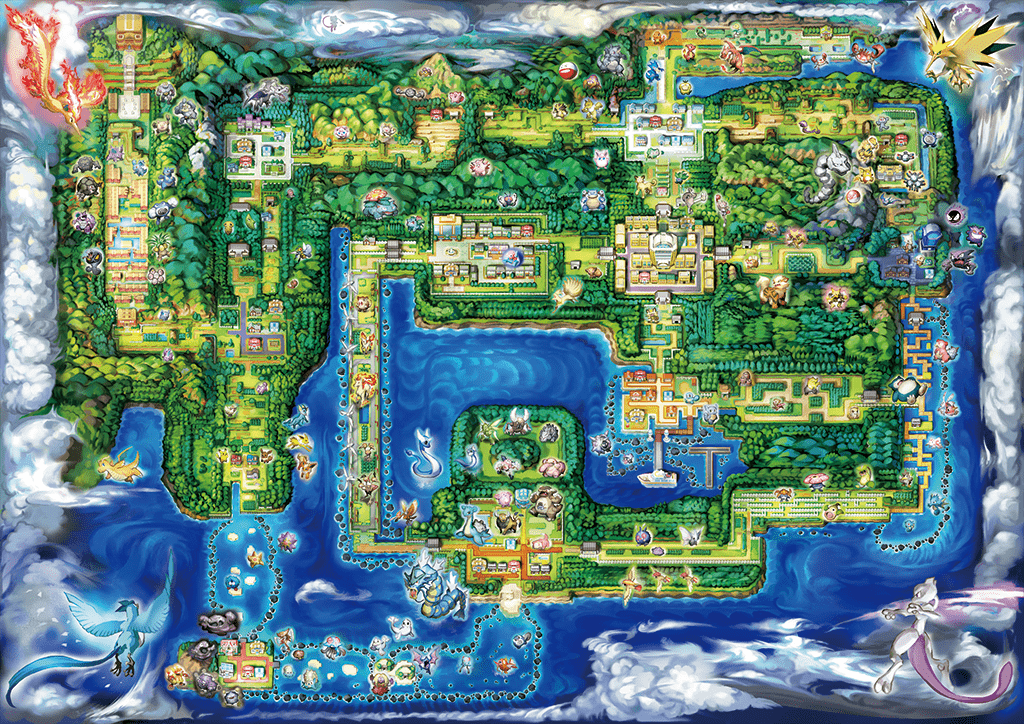

In [134]:
# Charger les données des villes avec latitude et longitude
locations = pd.DataFrame([
    {"name": "Plateau Indigo", "lat": 0.95, "lon": 0.13, "color": "red", "Pokémon": "None"},
    {"name": "Route Victoire", "lat": 0.70, "lon": 0.125, "color": "blue", "Pokémon": "Nosferapti, Nosferalto, Machop, Machopeur, Racaillou, Gravalanch, Onix, Ossatueur"},
    {"name": "Argenta", "lat": 0.79, "lon": 0.26, "color": "red", "Pokémon": "None"},
    {"name": "Forêt de Jade", "lat": 0.69, "lon": 0.26, "color": "blue", "Pokémon": "Chenipan, Aspicot, Roucool, Rattata, Nidoran F, Nidoran M"},
    {"name": "Bourg-Palette", "lat": 0.34, "lon": 0.24, "color": "red", "Pokémon": "Bulbizarre, Salamèche, Carapuce, Pikachu, Magicarpe, Ptitard, Poissirène, Tentacool, Stari"},
    {"name": "Cramois'Ile", "lat": 0.07, "lon": 0.24, "color": "red", "Pokémon": "Magicarpe, Ptitard, Poissirène, Tentacool, Crustabri, Hypotrempe, Stari"},
    {"name": "Iles écume", "lat": 0.06, "lon": 0.40, "color": "blue", "Pokémon": "Nosferapti, Nosferalto, Psykokwak, Akwakwak, Ramoloss, Flagadoss, Otaria, Crustabri, Krabby, Hypotrempe, Stari"},
    {"name": "Parmanie", "lat": 0.24, "lon": 0.50, "color": "red", "Pokémon": "Magicarpe, Ptitard, Poissirène, Poissoroy, Léviator"},
    {"name": "Parc Safari", "lat": 0.37, "lon": 0.50, "color": "blue", "Pokémon": "Tauros, Scarabrute, Kangourex, Nidorina, Nidorino"},
    {"name": "Lavanville", "lat": 0.64, "lon": 0.88, "color": "red", "Pokémon": "Spectrum, Fantominus, Ossatueur"},
    {"name": "Safrania", "lat": 0.65, "lon": 0.64, "color": "red", "Pokémon": "Kicklee, Tygnon"},
    {"name": "Carmin-sur-mer", "lat": 0.445, "lon": 0.64, "color": "red", "Pokémon": "Carapuce, Magicarpe, Ptitard, Poissirène, Tentacool, Crustabri, Krabby, Hypotrempe"},
    {"name": "Azuria", "lat": 0.815, "lon": 0.645, "color": "red", "Pokémon": "Bulbizarre, Magicarpe, Ptitard, Poissirène, Psykokwak, Krabby, Poissirène, Poissoroy"},
    {"name": "Céladopole", "lat": 0.65, "lon": 0.475, "color": "red", "Pokémon": "Magicarpe, Ptitard, Poissirène, Têtarte, Ramoloss"},
    {"name": "Mont Sélénite", "lat": 0.91, "lon": 0.43, "color": "blue", "Pokémon": "Racaillou, Nosferapti, Mélofée, Sabelette, Paras"},
    {"name": "Grotte Azurée", "lat": 0.90, "lon": 0.61, "color": "blue", "Pokémon": "Arbok, Métamorph, Dodrio, Ortide, Nosferalto, Poissirène, Gravalanch, Hypnomade, Kadabra, Krabboss, Magicarpe, Magnéton, Parasect, Ptitard, Raichu, Sablaireau, Hypocéan, Poissoroy, Flagadoss, Aéromite, Boustiflor"},
    {"name": "Point de fixation de la carte !", "lat": 0.94, "lon": 0.61, "color": "green", "Pokémon": "Aucun"},
    {"name": "Grotte Centrale", "lat": 0.77, "lon": 0.922, "color": "blue", "Pokémon": "Nosferapti, Machop, Racaillou, Onix"}
])

# Traduire les noms des Pokémon en anglais et générer les sprites
pokemon_translation = {
    "Nosferapti": "zubat", "Nosferalto": "golbat", "Machop": "machop", "Machopeur": "machoke",
    "Racaillou": "geodude", "Gravalanch": "graveler", "Onix": "onix", "Ossatueur": "marowak",
    "Chenipan": "caterpie", "Aspicot": "weedle", "Roucool": "pidgey", "Rattata": "rattata",
    "Nidoran F": "nidoran-f", "Nidoran M": "nidoran-m", "Bulbizarre": "bulbasaur",
    "Salamèche": "charmander", "Carapuce": "squirtle", "Pikachu": "pikachu",
    "Magicarpe": "magikarp", "Ptitard": "poliwag", "Poissirène": "goldeen",
    "Tentacool": "tentacool", "Stari": "staryu", "Crustabri": "cloyster",
    "Hypotrempe": "horsea", "Ramoloss": "slowpoke", "Flagadoss": "slowbro",
    "Krabby": "krabby", "Poissoroy": "seaking", "Léviator": "gyarados",
    "Tauros": "tauros", "Scarabrute": "pinsir", "Kangourex": "kangaskhan",
    "Spectrum": "haunter", "Fantominus": "gastly", "Kicklee": "hitmonlee",
    "Tygnon": "hitmonchan", "Mélofée": "clefairy", "Paras": "paras",
    "Kadabra": "kadabra", "Hypnomade": "drowzee", "Sablaireau": "sandslash",
    "Aéromite": "venomoth", "Boustiflor": "weepinbell", "Psykokwak": "psyduck", 
    "Akwakwak": "golduck", "Otaria" :"seel", "Nidorina": "nidorina", "Nidorino": "nidorino",
    "Magicarpe": "magikarp", "Têtarte": "poliwhirl", "Sabelette": "sandshrew",
    "Arbok": "arbok", "Métamorph": "ditto", "Dodrio": "dodrio", "Ortide": "gloom",
    "Krabboss": "kingler", "Magnéton": "magneton",
    "Parasect": "parasect", "Hypocéan": "seadra", "Raichu": "raichu", 
}

def popup_html(row):
    city_name = row['name']
    pokemon_list = row['Pokémon']
    if pokemon_list == "None" or pokemon_list == "Aucun":
        return f"<b>{city_name}</b><br>Aucun Pokémon"
    
    sprites = pokemon_list.split(', ')
    image_html = f"<b>{city_name}</b><br>"
    for pokemon in sprites:
        url = f"https://img.pokemondb.net/sprites/scarlet-violet/icon/{pokemon_translation.get(pokemon, pokemon)}.png"
        image_html += f'<img src="{url}" style="width:30px;height:30px;margin:2px;">'
    
    return image_html

# Charger l'image de la carte
image_path = "kanto_map.png"
kanto_map = Image.open(image_path)
map_width, map_height = kanto_map.size

# Créer une carte Folium
m = folium.Map(
    location=[0.5, 0.5],
    zoom_start=7,
    max_zoom=9,
    min_zoom=7,
    max_bounds=True,
    tiles=None,
    crs='Simple'
)

# Ajouter l'image de fond
folium.raster_layers.ImageOverlay(
    image=image_path,
    bounds=[[0, 0], [1, 1]],
    opacity=1,
    interactive=True,
    cross_origin=False,
    zindex=1,
).add_to(m)

# Ajouter les marqueurs pour chaque ville
for _, row in locations.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=folium.Popup(popup_html(row), max_width=300),
        color=row['color'],
        fill=True,
        fillColor=row['color']
    ).add_to(m)

# Ajuster les limites de la carte
m.fit_bounds([[0, 0], [1, 1]])

# Afficher la carte
m


<h2 style="padding:16px; color:#FFF; background:#07D">IV. Statistiques</h2>

<h2 style="padding:16px; color:#FFF; background:#000"> Proportion de Pokémons par types 
</h2>

In [136]:
def add_energy_image_column(data):
    """
    Ajoute une colonne avec les images d'énergie associées aux types de Pokémon.

    Parameters:
        data (pd.DataFrame): DataFrame contenant les types de Pokémon.

    Returns:
        pd.DataFrame: DataFrame enrichi avec une colonne d'images.
    """
    # Code HTML mis à jour pour inclure les énergies
    html_data = """
    <tr>
    <td><span typeof="mw:File"><a href="/Dragon_(JCC)" title="Dragon"><img alt="Dragon" src="/images/0/09/Miniature_Type_Dragon_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Dragon
    </td>
    <td><span typeof="mw:File"><a href="/Incolore_(JCC)" title="Incolore"><img alt="Incolore" src="/images/8/8a/Miniature_Type_Incolore_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Incolore
    </td>
    <td><span typeof="mw:File"><a href="/Plante_(JCC)" title="Plante"><img alt="Plante" src="/images/c/cd/Miniature_Type_Plante_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Plante
    </td>
    <td><span typeof="mw:File"><a href="/Feu_(JCC)" title="Feu"><img alt="Feu" src="/images/e/e5/Miniature_Type_Feu_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Feu
    </td>
    <td><span typeof="mw:File"><a href="/Eau_(JCC)" title="Eau"><img alt="Eau" src="/images/9/98/Miniature_Type_Eau_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Eau
    </td>
    <td><span typeof="mw:File"><a href="/%C3%89lectrique_(JCC)" title="Électrique"><img alt="Électrique" src="/images/4/41/Miniature_Type_%C3%89lectrique_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Électrique
    </td>
    <td><span typeof="mw:File"><a href="/Psy_(JCC)" title="Psy"><img alt="Psy" src="/images/e/e2/Miniature_Type_Psy_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Psy
    </td>
    <td><span typeof="mw:File"><a href="/Combat_(JCC)" title="Combat"><img alt="Combat" src="/images/1/13/Miniature_Type_Combat_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Combat
    </td>
    <td><span typeof="mw:File"><a href="/Obscurit%C3%A9_(JCC)" title="Obscurité"><img alt="Obscurité" src="/images/5/5a/Miniature_Type_Obscurit%C3%A9_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Obscurité
    </td>
    <td><span typeof="mw:File"><a href="/M%C3%A9tal_(JCC)" title="Métal"><img alt="Métal" src="/images/f/f9/Miniature_Type_M%C3%A9tal_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Métal
    </td>
    <td><span typeof="mw:File"><a href="/F%C3%A9e_(JCC)" title="Fée"><img alt="Fée" src="/images/d/d1/Miniature_Type_F%C3%A9e_JCC.png" decoding="async" width="25" height="25" class="mw-file-element"></a></span> Fée
    </td></tr>
    """

    # URL de base pour compléter les liens relatifs
    base_url = "https://www.pokepedia.fr"

    # Analyser le HTML avec BeautifulSoup
    soup = BeautifulSoup(html_data, "html.parser")

    # Extraire les informations
    types = []
    image_urls = []

    # Parcourir les colonnes du tableau HTML
    for td in soup.find_all("td"):
        img_tag = td.find("img")
        if img_tag:
            type_name = td.text.strip()
            img_src = img_tag["src"]
            full_url = base_url + img_src  # Compléter le lien relatif
            types.append(type_name)
            image_urls.append(full_url)

    # Créer un DataFrame à partir des données
    energy_df = pd.DataFrame({"Type": types, "Image_URL": image_urls})

    # Modifier les noms des types si nécessaire
    energy_df["Type"] = energy_df["Type"].replace({
        "Fée": "Fee",
        "Incolore": "Normal",
        "Électrique": "Electrik",
        "Obscurité": "Spectre",
        "Métal": "Acier"
    })

    # Ajouter une colonne avec le HTML des images pour affichage
    energy_df["Image"] = energy_df["Image_URL"].apply(
        lambda url: f'<img src="{url}" width="25" height="25">'
    )

    # Ajouter une colonne avec les images d'énergie associées aux types dans le DataFrame de comptage
    if 'Type' in data.columns:
        data = data.merge(energy_df[['Type', 'Image']], on='Type', how='left')
        return data
    else:
        print("La colonne 'Type' n'existe pas dans les données.")
        return data

# Exemple d'utilisation avec un DataFrame de comptage des types de Pokémon
pokemon_type_counts = pd.DataFrame({
    "Type": ["Dragon", "Normal", "Plante", "Feu", "Eau", "Electrik", "Psy", "Combat", "Spectre", "Acier", "Fee"],
    "Count": [10, 20, 15, 12, 8, 14, 7, 9, 6, 5, 3]
})

enriched_pokemon_type_counts = add_energy_image_column(pokemon_type_counts)

# Afficher le tableau enrichi
display(HTML(enriched_pokemon_type_counts.to_html(escape=False, index=False)))

# Exporter les données enrichies
enriched_pokemon_type_counts.to_csv("enriched_pokemon_types.csv", index=False)


Type,Count,Image
Dragon,10,
Normal,20,
Plante,15,
Feu,12,
Eau,8,
Electrik,14,
Psy,7,
Combat,9,
Spectre,6,
Acier,5,


<h2 style="padding:16px; color:#FFF; background:#000"> Etude de cas : Evolution du prix en fonction du grade de la carte   </h2>

In [138]:
# Charger le fichier CSV
input_file = "pokemon_base_set_prices_cleaned.csv"
data = pd.read_csv(input_file)

# Supprimer les lignes avec des valeurs manquantes pour les calculs
filtered_data = data.dropna(subset=["Prix non gradé $", "Grade 9 $", "Grade 10 $"]).copy()

# Calcul des différences de prix
filtered_data.loc[:, "Diff Non Gradé - Grade 9"] = filtered_data["Grade 9 $"] - filtered_data["Prix non gradé $"]
filtered_data.loc[:, "Diff Non Gradé - Grade 10"] = filtered_data["Grade 10 $"] - filtered_data["Prix non gradé $"]
filtered_data.loc[:, "Diff Grade 9 - Grade 10"] = filtered_data["Grade 10 $"] - filtered_data["Grade 9 $"]

# Inclure les colonnes des différences dans un seul DataFrame avec les données originales
merged_data = filtered_data[["Nom de la carte", 
                             "Diff Non Gradé - Grade 9", "Diff Non Gradé - Grade 10", "Diff Grade 9 - Grade 10"]]

# Style pour rendre le DataFrame visuellement plaisant
styled_data = merged_data.style.set_table_styles([
    {"selector": "thead th", "props": "background-color: #2c3e50; color: white; text-align: center;"},
    {"selector": "tbody td", "props": "border: 1px solid #ddd; text-align: center;"},
    {"selector": "tbody tr:nth-child(even)", "props": "background-color: #f2f2f2;"},
    {"selector": "tbody tr:hover", "props": "background-color: #dcdcdc;"}
]).background_gradient(
    subset=["Diff Non Gradé - Grade 9", "Diff Non Gradé - Grade 10", "Diff Grade 9 - Grade 10"], 
    cmap=sns.color_palette("YlOrRd", as_cmap=True))

# Afficher le DataFrame stylisé
display(styled_data)

# Calcul des statistiques
stats = {
    "Diff Non Gradé - Grade 9": filtered_data["Diff Non Gradé - Grade 9"].describe(),
    "Diff Non Gradé - Grade 10": filtered_data["Diff Non Gradé - Grade 10"].describe(),
    "Diff Grade 9 - Grade 10": filtered_data["Diff Grade 9 - Grade 10"].describe(),
}

# Fonction pour afficher les statistiques de manière formatée
def display_statistics(label, description):
    print(f"\n=== {label} ===")
    print(f"Nombre de cartes: {description['count']:.0f}")
    print(f"Moyenne: {description['mean']:.2f} $")
    print(f"Écart-type: {description['std']:.2f} $")
    print(f"Minimum: {description['min']:.2f} $")
    print(f"25e centile: {description['25%']:.2f} $")
    print(f"Médiane (50e centile): {description['50%']:.2f} $")
    print(f"75e centile: {description['75%']:.2f} $")
    print(f"Maximum: {description['max']:.2f} $")

# Moyennes des différences
mean_diff_non_graded_grade9 = filtered_data["Diff Non Gradé - Grade 9"].mean()
mean_diff_non_graded_grade10 = filtered_data["Diff Non Gradé - Grade 10"].mean()
mean_diff_grade9_grade10 = filtered_data["Diff Grade 9 - Grade 10"].mean()



,Nom de la carte,Diff Non Gradé - Grade 9,Diff Non Gradé - Grade 10,Diff Grade 9 - Grade 10
0,Charizard #4,973.700000,10306.260000,9332.560000
1,Charizard [1st Edition] #4,15889.800000,247683.040000,231793.240000
2,Machamp [1st Edition] #8,121.300000,1057.920000,936.620000
3,Blastoise #2,338.150000,2633.490000,2295.340000
4,Charizard [Shadowless] #4,3773.330000,33373.980000,29600.650000
5,Venusaur #15,254.420000,1444.340000,1189.920000
6,Mewtwo #10,134.250000,644.160000,509.910000
7,Blastoise [1st Edition] #2,3049.350000,19678.950000,16629.600000
8,Gyarados #6,107.640000,498.280000,390.640000
9,Alakazam #1,113.050000,723.850000,610.800000


<h2 style="padding:16px; color:#FFF; background:#000">  Proportions des cartes en fonction de leur prix  </h2>

In [140]:
# Charger le fichier CSV
input_file = "pokemon_base_set_prices_cleaned.csv"
data = pd.read_csv(input_file)

# Supprimer les lignes avec des valeurs manquantes pour les calculs
filtered_data = data.dropna(subset=["Prix non gradé $", "Grade 9 $", "Grade 10 $"]).copy()

# Fonction pour catégoriser les prix et ajouter les fourchettes de prix
def categorize_price(row, grade_col):
    if row[grade_col] < 100:
        return "Faible"
    elif row[grade_col] < 1000:
        return "Moyen"
    else:
        return "Élevé"

def price_range(category):
    if category == "Faible":
        return "(entre 0 et 99 $)"
    elif category == "Moyen":
        return "(entre 100 et 999 $)"
    elif category == "Élevé":
        return "(>= 1000 $)"

grades = ["Prix non gradé $", "Grade 9 $", "Grade 10 $"]

# Ajouter des colonnes de catégories de prix et leurs fourchettes
for grade in grades:
    filtered_data[f"{grade} Catégorie"] = filtered_data.apply(categorize_price, grade_col=grade, axis=1)
    filtered_data[f"{grade} Catégorie"] = filtered_data[f"{grade} Catégorie"] + " " + filtered_data[f"{grade} Catégorie"].apply(price_range)

# Calcul des proportions par catégorie pour chaque grade
proportions = {}
for grade in grades:
    proportions[grade] = filtered_data[f"{grade} Catégorie"].value_counts(normalize=True) * 100

# Créer un DataFrame des proportions pour affichage
proportions_df = pd.DataFrame({
    grade: proportions[grade] for grade in grades
}).fillna(0)

# Style pour rendre les proportions esthétiques avec des bordures autour des catégories
styled_proportions = proportions_df.style.set_table_styles([
    {"selector": "thead th", "props": "background-color: pink; color: black; text-align: center; border: 2px solid black;"},
    {"selector": "tbody td", "props": "border: 2px solid black; text-align: center;"},
    {"selector": "tbody tr:nth-child(even)", "props": "background-color: #f9f9f9; border: 2px solid black;"},
    {"selector": "tbody tr:hover", "props": "background-color: #f1f1f1; border: 2px solid black;"}
]).format("{:.2f} %")

# Afficher les proportions stylisées
display(HTML("<h3>Proportions des catégories de prix par grade</h3>"))
display(styled_proportions)


,Prix non gradé $,Grade 9 $,Grade 10 $
Faible (entre 0 et 99 $),61.70 %,27.66 %,4.26 %
Moyen (entre 100 et 999 $),34.04 %,42.55 %,36.17 %
Élevé (>= 1000 $),4.26 %,29.79 %,59.57 %


<h2 style="padding:16px; color:#FFF; background:#000">  Cartes les plus rentables en termes de gradation </h2>

In [142]:
# Calculer les différences de prix pour la rentabilité
data["Diff Non Gradé - Grade 10"] = data["Grade 10 $"] - data["Prix non gradé $"]

# Trier par différence décroissante
most_profitable_cards = data.sort_values(by="Diff Non Gradé - Grade 10", ascending=False).head(10)

# Préparer le DataFrame pour un affichage lisible
columns_to_display = ["Nom de la carte", "Prix non gradé $", "Grade 10 $", "Diff Non Gradé - Grade 10"]
most_profitable_display = most_profitable_cards[columns_to_display].copy()

# Formater les colonnes en ajoutant le symbole $
for col in ["Prix non gradé $", "Grade 10 $", "Diff Non Gradé - Grade 10"]:
    most_profitable_display[col] = most_profitable_display[col].apply(lambda x: f"{x:,.2f} $")

# Afficher le tableau avec un style amélioré
styled_display = most_profitable_display.style.set_table_styles([
    {"selector": "thead th", "props": [("background-color", "#00F"), ("color", "white"), ("text-align", "center")]},
    {"selector": "tbody td", "props": [("border", "1px solid black"), ("text-align", "center")]},
    {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f9f9f9")]},
    {"selector": "tbody tr:hover", "props": [("background-color", "#f1f1f1")]}
])

# Afficher le tableau stylisé
display(HTML("<h3> Cartes les plus rentables en termes de Gradation </h3>"))
display(styled_display)


,Nom de la carte,Prix non gradé $,Grade 10 $,Diff Non Gradé - Grade 10
1,Charizard [1st Edition] #4,"3,655.20 $","251,338.24 $","247,683.04 $"
44,Chansey [1st Edition] #3,253.64 $,"46,772.74 $","46,519.10 $"
4,Charizard [Shadowless] #4,476.37 $,"33,850.35 $","33,373.98 $"
7,Blastoise [1st Edition] #2,813.14 $,"20,492.09 $","19,678.95 $"
19,Venusaur [1st Edition] #15,885.16 $,"12,676.60 $","11,791.44 $"
0,Charizard #4,288.80 $,"10,595.06 $","10,306.26 $"
34,Alakazam [1st Edition] #1,322.12 $,"10,300.00 $","9,977.88 $"
38,Gyarados [1st Edition] #6,230.00 $,"10,000.00 $","9,770.00 $"
17,Mewtwo [1st Edition] #10,366.33 $,"8,550.00 $","8,183.67 $"
14,Charizard [1999-2000] #4,206.75 $,"7,785.42 $","7,578.67 $"


<h2 style="padding:16px; color:#FFF; background:#000">  Cartes les plus chères globalement </h2>

In [144]:
# Identifier les grades étudiés
grades = ["Prix non gradé $", "Grade 9 $", "Grade 10 $"]

# Couleurs pour chaque tableau
table_colors = {
    "Prix non gradé $": "#013220",  # Vert sapin
    "Grade 9 $": "#800020",        # Rouge bordeaux
    "Grade 10 $": "#87CEEB"         # Bleu ciel
}

# Identifier les cartes les plus chères pour chaque grade
top_expensive_cards = {}
for grade in grades:
    top_expensive_cards[grade] = data.sort_values(by=grade, ascending=False).head(10)

# Afficher les résultats sous forme de tableaux stylisés
for grade, top_cards in top_expensive_cards.items():
    # Préparer le DataFrame pour affichage
    top_cards_display = top_cards[["Nom de la carte", grade]].copy()

    # Formater les colonnes en ajoutant le symbole $
    top_cards_display[grade] = top_cards_display[grade].apply(lambda x: f"{x:,.2f} $")

    # Récupérer la couleur pour le tableau
    header_color = table_colors.get(grade, "#4CAF50")

    # Styliser le tableau avec des styles corrects
    styled_display = top_cards_display.style.set_table_styles([
        {"selector": "thead th", "props": [("background-color", header_color), ("color", "white"), ("text-align", "center")]},
        {"selector": "tbody td", "props": [("border", "1px solid black"), ("text-align", "center")]},
        {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f9f9f9")]},
        {"selector": "tbody tr:hover", "props": [("background-color", "#f1f1f1")]}
    ])

    # Afficher le tableau stylisé
    display(HTML(f"<h3>Cartes les plus chères pour {grade}</h3>"))
    display(styled_display)


,Nom de la carte,Prix non gradé $
26,Booster Box [1st Edition],"153,042.29 $"
48,Booster Box,"12,356.31 $"
33,Booster Pack [1st Edition],"6,626.02 $"
1,Charizard [1st Edition] #4,"3,655.20 $"
41,Pikachu [E3 Red Cheeks] #58,916.22 $
19,Venusaur [1st Edition] #15,885.16 $
7,Blastoise [1st Edition] #2,813.14 $
4,Charizard [Shadowless] #4,476.37 $
28,Booster Pack,464.34 $
17,Mewtwo [1st Edition] #10,366.33 $


,Nom de la carte,Grade 9 $
1,Charizard [1st Edition] #4,"19,545.00 $"
33,Booster Pack [1st Edition],"4,938.15 $"
4,Charizard [Shadowless] #4,"4,249.70 $"
7,Blastoise [1st Edition] #2,"3,862.49 $"
19,Venusaur [1st Edition] #15,"2,750.00 $"
14,Charizard [1999-2000] #4,"2,235.53 $"
17,Mewtwo [1st Edition] #10,"1,992.58 $"
34,Alakazam [1st Edition] #1,"1,787.50 $"
44,Chansey [1st Edition] #3,"1,632.83 $"
38,Gyarados [1st Edition] #6,"1,413.76 $"


,Nom de la carte,Grade 10 $
1,Charizard [1st Edition] #4,"251,338.24 $"
44,Chansey [1st Edition] #3,"46,772.74 $"
4,Charizard [Shadowless] #4,"33,850.35 $"
7,Blastoise [1st Edition] #2,"20,492.09 $"
19,Venusaur [1st Edition] #15,"12,676.60 $"
0,Charizard #4,"10,595.06 $"
34,Alakazam [1st Edition] #1,"10,300.00 $"
38,Gyarados [1st Edition] #6,"10,000.00 $"
17,Mewtwo [1st Edition] #10,"8,550.00 $"
14,Charizard [1999-2000] #4,"7,785.42 $"


<h2 style="padding:16px; color:#FFF; background:#000"> Analyse des augmentations de prix en pourcentage </h2>

In [146]:
# Calcul des augmentations en pourcentage
data["Augmentation Non Gradé -> Grade 9 (%)"] = ((data["Grade 9 $"] - data["Prix non gradé $"]) / data["Prix non gradé $"]) * 100
data["Augmentation Non Gradé -> Grade 10 (%)"] = ((data["Grade 10 $"] - data["Prix non gradé $"]) / data["Prix non gradé $"]) * 100
data["Augmentation Grade 9 -> Grade 10 (%)"] = ((data["Grade 10 $"] - data["Grade 9 $"]) / data["Grade 9 $"]) * 100

# Trier par les plus grandes augmentations
top_increases = data.sort_values(by="Augmentation Non Gradé -> Grade 10 (%)", ascending=False).head(10)

# Préparer le DataFrame pour affichage
columns_to_display = ["Nom de la carte", "Prix non gradé $", "Grade 10 $", "Augmentation Non Gradé -> Grade 10 (%)"]
top_increases_display = top_increases[columns_to_display].copy()

# Formater les colonnes en ajoutant le symbole $
for col in ["Prix non gradé $", "Grade 10 $"]:
    top_increases_display[col] = top_increases_display[col].apply(lambda x: f"{x:,.2f} $")

# Formater les pourcentages
top_increases_display["Augmentation Non Gradé -> Grade 10 (%)"] = top_increases_display["Augmentation Non Gradé -> Grade 10 (%)"].apply(lambda x: f"{x:,.2f} %")

# Styliser le tableau avec des styles corrects
styled_display = top_increases_display.style.set_table_styles([
    {"selector": "thead th", "props": [
        ("background-color", "#013220"), ("color", "white"), ("text-align", "center")
    ]},
    {"selector": "tbody td", "props": [
        ("border", "1px solid black"), ("text-align", "center")
    ]},
    {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f9f9f9")]},
    {"selector": "tbody tr:hover", "props": [("background-color", "#f1f1f1")]}
])

# Afficher le tableau stylisé
display(HTML("<h3>Cartes avec les plus grandes augmentations (Non Gradé -> Grade 10)</h3>"))
display(styled_display)


,Nom de la carte,Prix non gradé $,Grade 10 $,Augmentation Non Gradé -> Grade 10 (%)
44,Chansey [1st Edition] #3,253.64 $,"46,772.74 $","18,340.60 %"
16,Chansey #3,14.97 $,"2,434.44 $","16,162.12 %"
30,Machamp [Shadowless] #8,13.48 $,"2,050.79 $","15,113.58 %"
20,Hitmonchan #7,6.96 $,750.00 $,"10,675.86 %"
42,Mewtwo [Shadowless] #10,30.29 $,"3,150.00 $","10,299.47 %"
37,Clefairy #5,12.00 $,"1,112.50 $","9,170.83 %"
47,Gyarados [Shadowless] #6,27.99 $,"2,400.00 $","8,474.49 %"
18,Raichu #14,12.99 $,"1,095.56 $","8,333.87 %"
4,Charizard [Shadowless] #4,476.37 $,"33,850.35 $","7,005.89 %"
1,Charizard [1st Edition] #4,"3,655.20 $","251,338.24 $","6,776.18 %"


<h2 style="padding:16px; color:#FFF; background:#000">  Distribution des prix </h2>

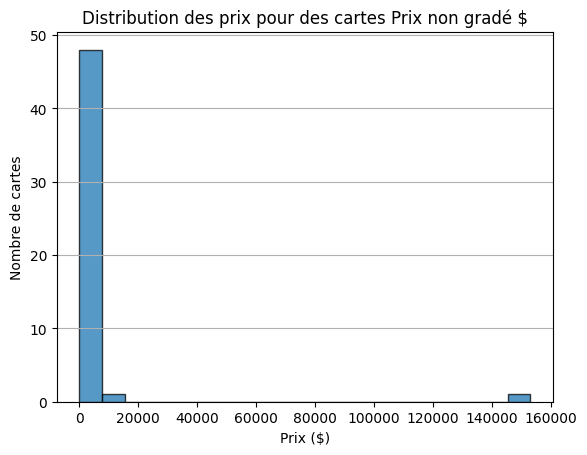

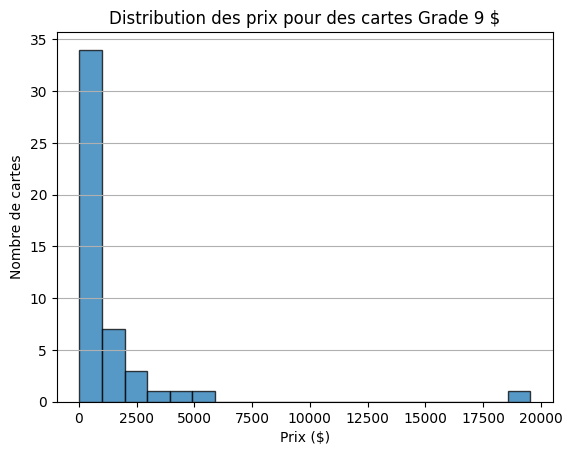

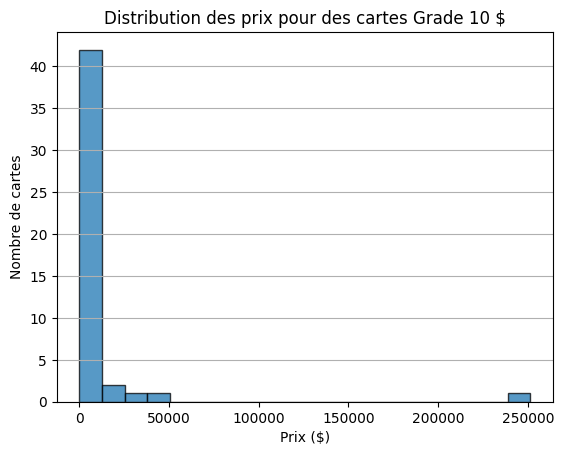

In [148]:
grades = ["Prix non gradé $", "Grade 9 $", "Grade 10 $"]

# Histogrammes
for grade in grades:
    plt.figure()
    plt.hist(data[grade].dropna(), bins=20, alpha=0.75, edgecolor='black')
    plt.title(f"Distribution des prix pour des cartes {grade}")
    plt.xlabel("Prix ($)")
    plt.ylabel("Nombre de cartes")
    plt.grid(axis='y')
    plt.show()


*Veuillez noter que pour les deux premiers graphiques, l'échelle n'est pas adaptée à la distribution correcte des prix : elle est faussée par les éléments Booster Box et Booser Pack qui correspondent aux packs et display (boîte avec plusieurs packs) du Set de Base.* 

<h2 style="padding:16px; color:#FFF; background:#07D">V. Conclusion</h2>

**Ce projet Pokémon a permis d'explorer et d'analyser en profondeur les données liées aux cartes du Set de Base et aux Pokémon de la région de Kanto. Grâce à des visualisations interactives, des analyses statistiques détaillées et une présentation élégante, nous avons mis en lumière les dynamiques de prix et les caractéristiques des cartes les plus emblématiques. En combinant des données web et des outils modernes de traitement, ce projet illustre la richesse des informations que l'on peut extraire d'un domaine aussi captivant que l'univers Pokémon. Merci pour votre attention**